# adverSCarial
*adverSCarial* is a list of functions aiming to run adversarial attack on single cell classification algorithms.


# Classifier Verification
In this notebook we load a randomForest cell type classifier and verify that it classifies correctly each cluster of the pbmc Seurat object.

In [1]:
# Libraries
library(randomForest)
library(Seurat)
library(stringr)
# Notebook plot sizes
options(repr.plot.width=15, repr.plot.height=12)

# Seurat object
pbmc = readRDS("data/datasets/pbmc.rds")
# classifier: classifier in rf object
load("classifiers/rf_scrnaseq")

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Attaching SeuratObject



# Look at the pbmc object

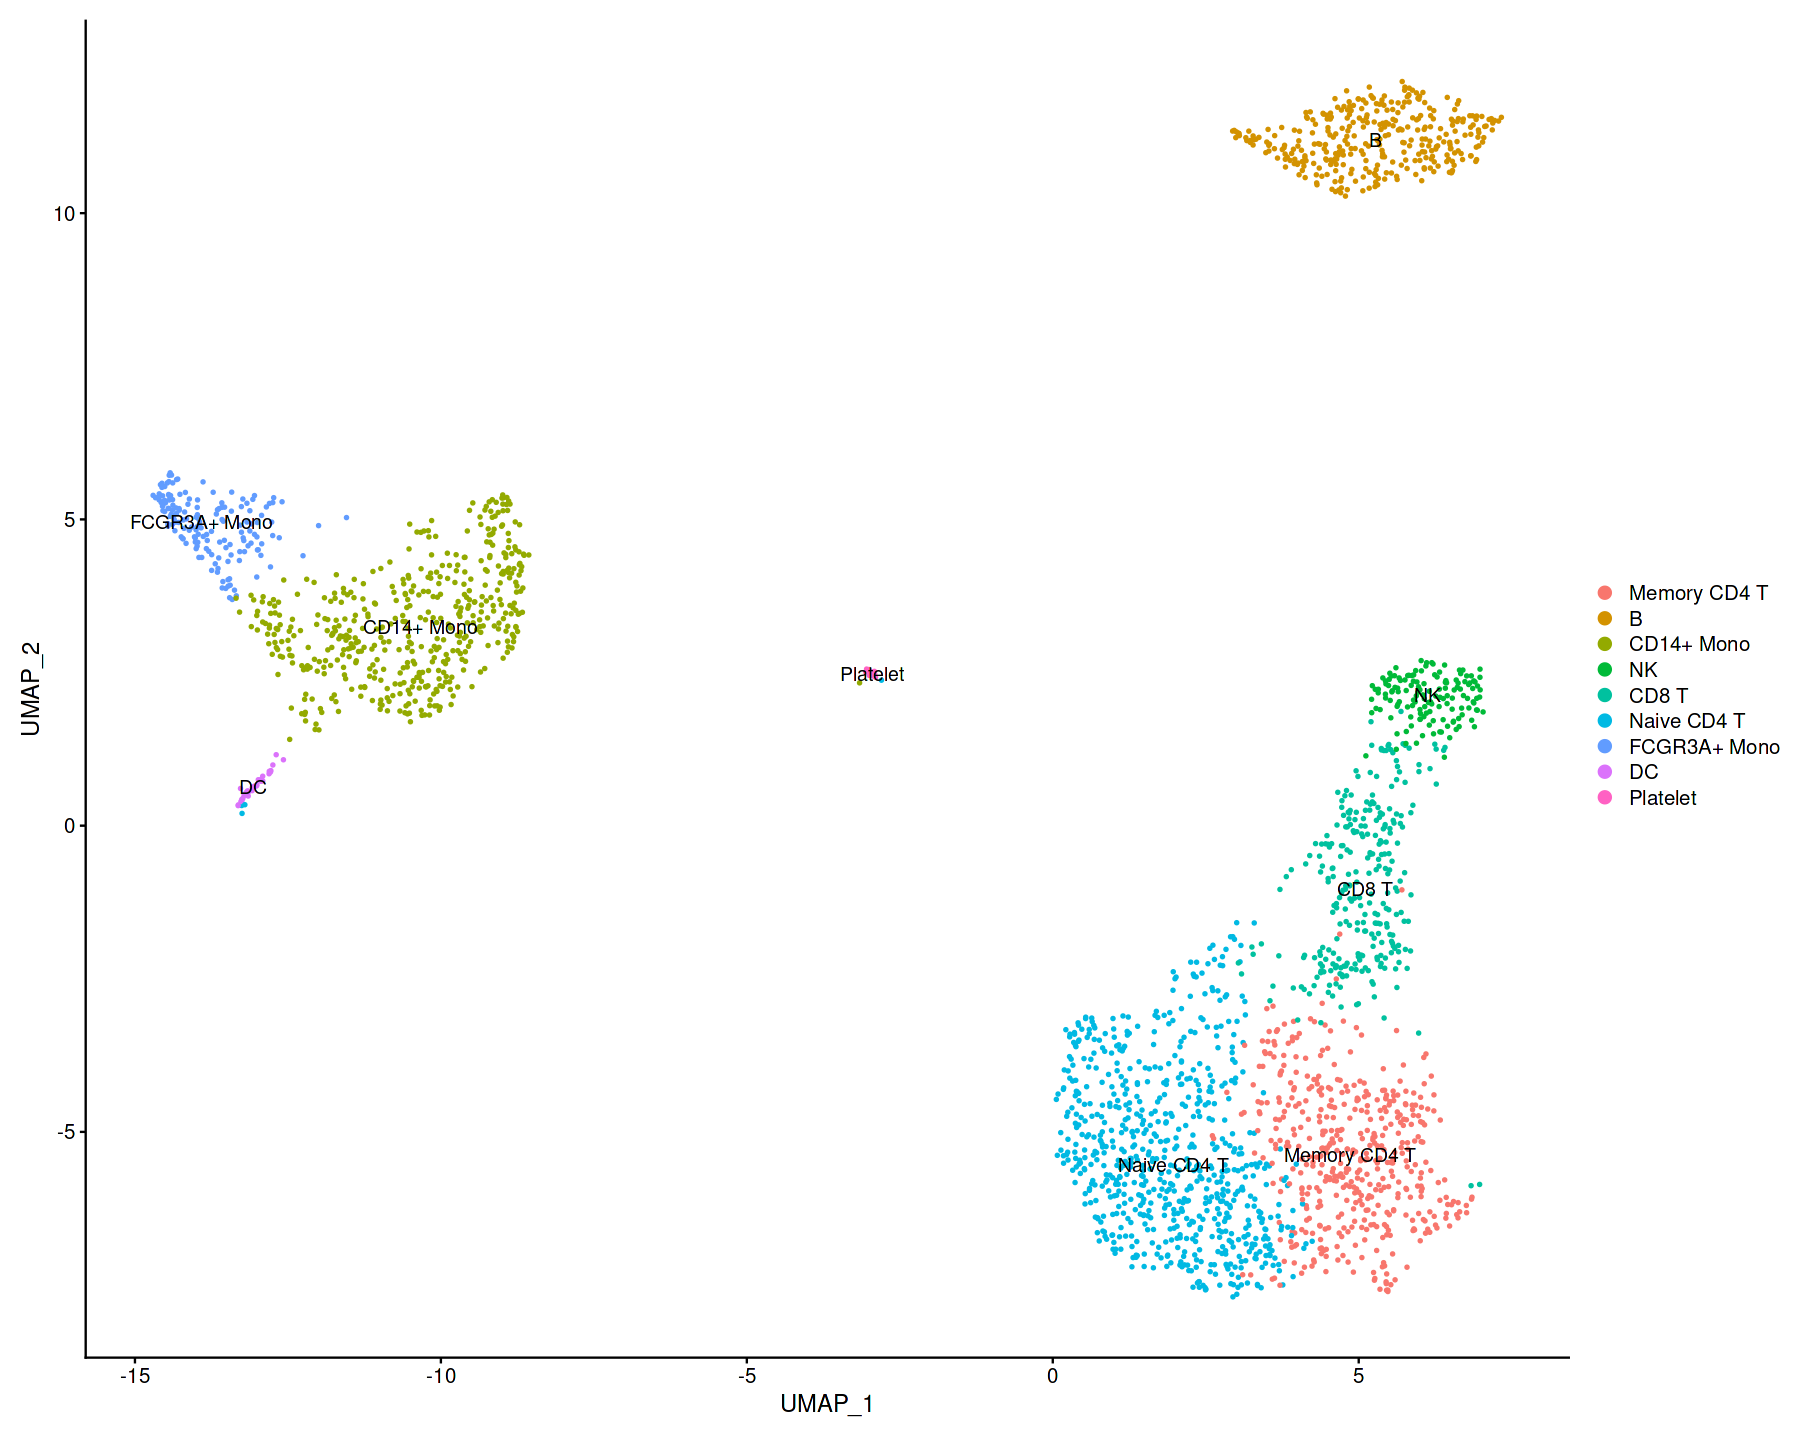

In [2]:
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5)

In [3]:
# Retrieve needed data from pbmc object
rna_matrix = t(as.matrix(pbmc@assays$RNA@counts))
clusters_id = pbmc@meta.data$manual_annotation

# Verification of the classifier
Let's check that the `rf` classifier classifies each cell cluster correctly

`rf` is a RandomForest classifier that, when given a list of RNA values for a cell, returns a specific cell type from that list. We need to adjust the classifier so that it can assign a cell type to a group of cells.
    
A classifier function has to be formated as follow to be used with *adverSCarial*:
```R
    classifier = function(expr, clusters, target){
                
                
                c("cell type", trust)
    }
```
    
The matrix `expr` contains RNA expression values, the list `clusters` consists of the cluster IDs for each cell in `expr`, and `target` is the ID of the cluster for which we want to have a classification. The function returns a vector with the classification result, and a trust indice.

In [4]:
RFClassifier = function(expr, clusters, target){
    set.seed(20)
    colnames(expr) = str_replace_all(colnames(expr),"-","_")
    colnames(expr) = str_replace(colnames(expr),"^","g_")
    
    rf_features = names(rf$forest$xlevels)
    c_diff_genes = setdiff(rf_features, colnames(expr))
    expr = as.data.frame(expr)
    expr[,c_diff_genes] = 0
    
    final_predictions = predict(rf, expr[clusters==target,])
    ratio = as.numeric(sort(table(final_predictions), decreasing = T)[1]) / sum(as.numeric(sort(table(final_predictions), decreasing = T)))
    predicted_class = names(sort(table(final_predictions), decreasing = T)[1])
    if ( ratio < 0.5){
        predicted_class = "NA"
    }
    c(predicted_class, ratio)
}

In [5]:
# Add metadata auto_annotation to Seurat object
pbmc[["auto_annotation"]] = ""

for ( str_cluster in sort(unique(pbmc@meta.data$manual_annotation))){
    autom_classification = RFClassifier(rna_matrix, clusters_id, str_cluster)
    autom_classification = autom_classification[1]
    pbmc@meta.data[pbmc@meta.data$manual_annotation == str_cluster, "auto_annotation"] = autom_classification
    message(paste("Cluster",str_cluster,"is",autom_classification))
}

Cluster B is B

Cluster CD14+ Mono is CD14+ Mono

Cluster CD8 T is CD8 T

Cluster DC is DC

Cluster FCGR3A+ Mono is FCGR3A+ Mono

Cluster Memory CD4 T is Memory CD4 T

Cluster Naive CD4 T is Naive CD4 T

Cluster NK is NK

Cluster Platelet is Platelet



## Check that the classifier *auto_annotation* give the same results as manul *manual_nnotation*

In [6]:
all(pbmc@meta.data$auto_annotation == pbmc@meta.data$manual_annotation)

[1] TRUE

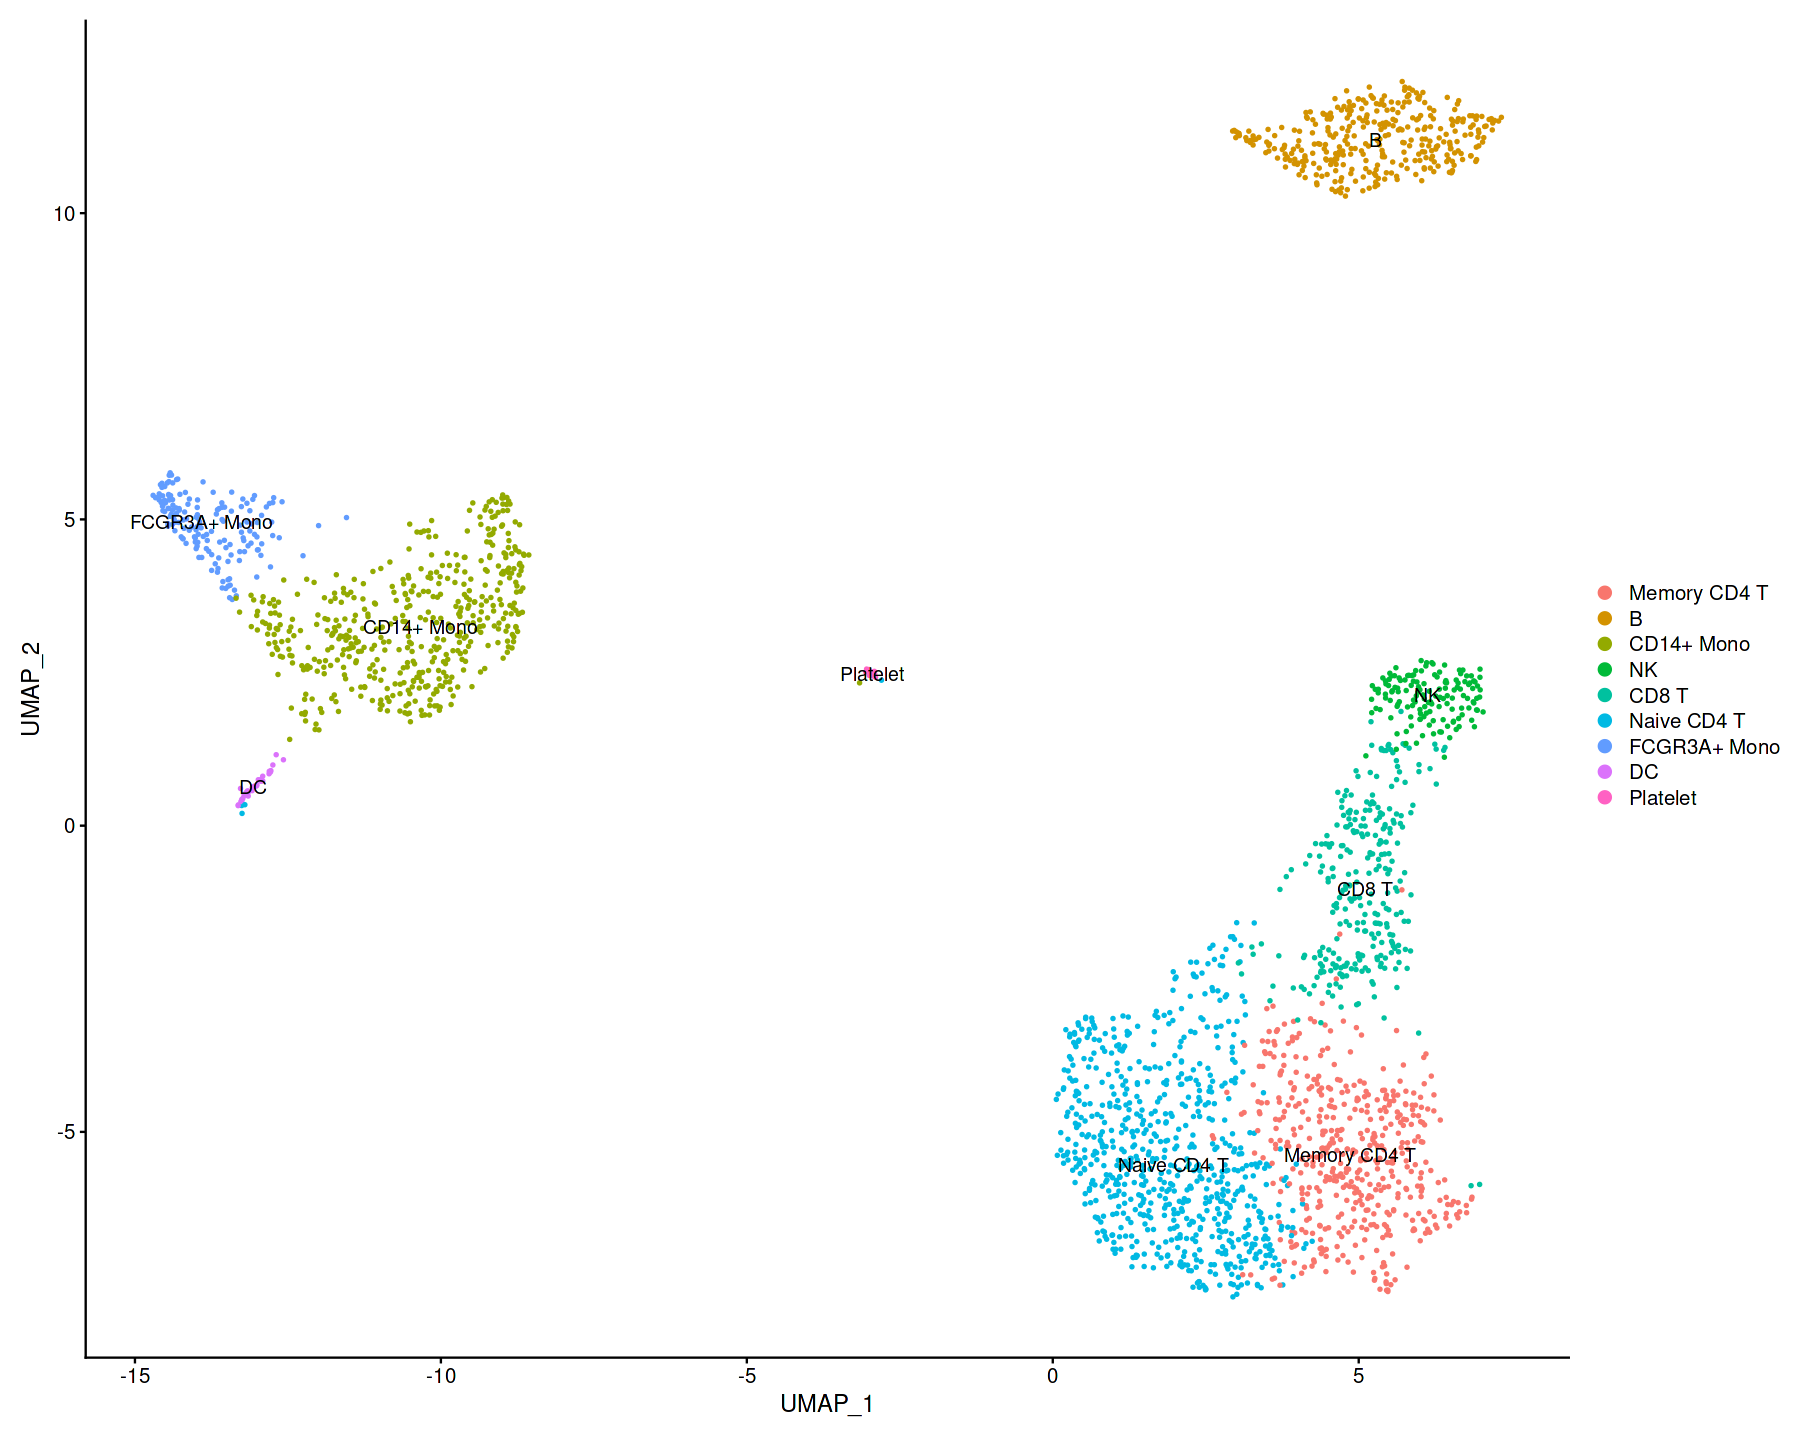

In [7]:
Idents(pbmc) = "auto_annotation"
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5)

# Everything ok